In [1]:
import pandas as pd
import numpy as np 
import json
import os
import re
from gensim.parsing.preprocessing import strip_multiple_whitespaces

import matplotlib.pyplot as plt
import seaborn as sns

cameo_to_penta = {
    "Make Public Statement" : "Make a Statement",
    "Appeal" : "Make a Statement", 
    "Express Intend to Cooperate" : "Verbal Cooperation",
    "Consult" : "Verbal Cooperation",
    "Engage In Diplomatic Cooperation" : "Verbal Cooperation",
    "Engage In Material Cooperation" : "Material Cooperation",
    "Provide Aid" : "Material Cooperation",
    "Yield" : "Material Cooperation", 
    "Investigate" : "Verbal Conflict",
    "Demand" : "Verbal Conflict",
    "Disapprove" : "Verbal Conflict",
    "Reject" : "Verbal Conflict",
    "Threaten" : "Verbal Conflict",
    "Exhibit Military Posture" : "Material Conflict",
    "Protest" : "Material Conflict", 
    "Reduce Relations" : "Verbal Conflict",
    "Coerce" : "Material Conflict",
    "Assault" : "Material Conflict",
    "Fight" : "Material Conflict",
    "Engage in unconventional mass violence" : "Material Conflict",
    "Engage In Unconventional Mass Violence" : "Material Conflict"
}

In [3]:
os.chdir("..")
#for pretrain data
data = pd.read_csv("soft_data/data/out_data/softdata_concat_noents.csv", index_col = 0)
data.shape

(24674, 2)

In [4]:
#check for duplicated inputs
data.text.duplicated().any()

False

In [5]:
#example lines
data.head()

,text,label
0,This is a worrying sign because it's different...,<triplet> Shivshankar Menon <subj> interviewer...
1,Indian students have flocked to Chinese univer...,<triplet> Indian students <subj> Chinese unive...
2,Actress Salma Hayek has also used Actress Salm...,<triplet> Actress Salma Hayek <subj> Actress S...
3,"a soldier's sister, Mayra, told NBC that Ms Gu...",<triplet> NBC <subj> Ms Guillen's sister <obj>...
4,When BBC Gujarati's Roxy Gadgekar's sister She...,<triplet> BBC Gujarati's Roxy Gadgekar <subj> ...


# General EDA

<AxesSubplot: xlabel='text_len'>

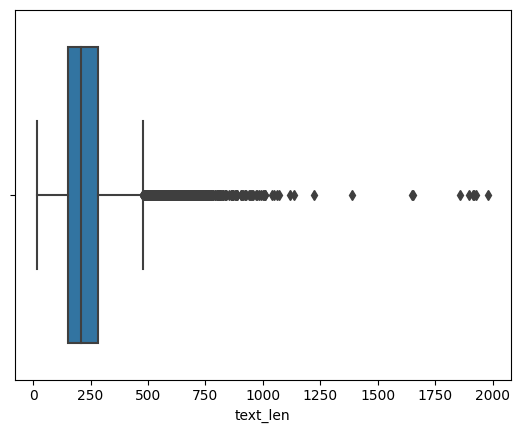

In [6]:
data["text_len"] = data.text.apply(lambda x: len(x))
sns.boxplot(x = data.text_len)

#there is an unsreasonable amount of data with very long texts.
#this might be a problem, since most text are sentences.
#500 seems like a reasonable cut-off to have data more uniform

In [7]:
data = data[data.text_len < 500]
data.shape

(24033, 3)

In [8]:
#How many relations does each text have?
data["rel_count"] = data.label.apply(lambda x: x.count("<triplet>"))
for count in range(data.rel_count.max()):
    print(f"Count of sentences with {count + 1} relations: {data[data.rel_count == count + 1].shape[0]}")

#all sentences have only 1 relation

Count of sentences with 1 relations: 23352
Count of sentences with 2 relations: 659
Count of sentences with 3 relations: 22


# EDA with CAMEO codes

Text(0.5, 0, 'Label')

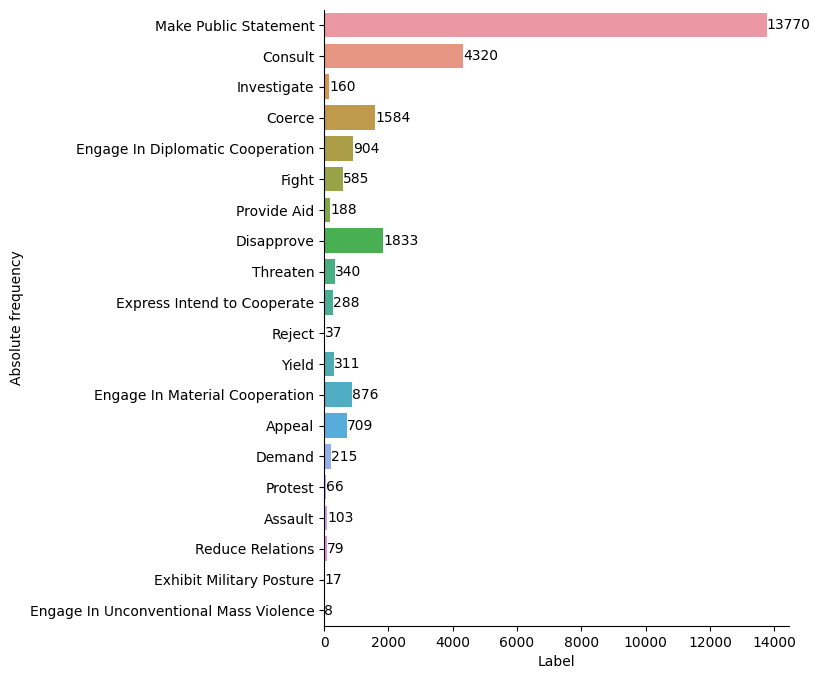

In [9]:
#extract the categorized relation
data["label"] = data.label.apply(lambda x: strip_multiple_whitespaces(x.replace("<triplet>"," <triplet> ")))
relation = []
for row in data.iterrows():
    rel_iter = row[1]["label"] + " <triplet>"
    all_rels = re.findall("(?<=<obj> ).*?(?= <subj> | <triplet>)", rel_iter)
    relation.append(all_rels)
data["relations"] = relation 

expl = data.explode("relations")
plt.figure(figsize=(6,8))
ax = sns.countplot(y = expl.relations)
ax.bar_label(ax.containers[0])
sns.despine()
plt.ylabel('Absolute frequency')
plt.xlabel('Label')

In [10]:
#address class imbalance with downsampling 
data["mps"] = data.label.apply(lambda x: "Make Public Statement" in x)
data["consult"] = data.label.apply(lambda x: "Consult" in x)

#data without consult or mps labels
data_1 = data[(data.mps == False) & (data.consult == False)]

#only mps / cons
data_mps = data[data.mps == True]
data_cons = data[data.consult == True]

#sort mps and cons data to prefer data with more relations to reduce removing of other labels than these two
data_mps["count_rels"] = data_mps.relations.apply(lambda x: len(x))
data_cons["count_rels"] = data_cons.relations.apply(lambda x: len(x))

data_mps.sort_values("count_rels", ascending = False, inplace = True)
data_cons.sort_values("count_rels", ascending = False, inplace = True)

#reduce to next best length (being disapprove)
data_new = pd.concat([data_1,data_mps.sample(n = 2700),data_cons.sample(n = 2700)])

C:\Users\svawe\AppData\Local\Temp\ipykernel_26940\2793995320.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_mps["count_rels"] = data_mps.relations.apply(lambda x: len(x))
C:\Users\svawe\AppData\Local\Temp\ipykernel_26940\2793995320.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cons["count_rels"] = data_cons.relations.apply(lambda x: len(x))
C:\Users\svawe\AppData\Local\Temp\ipykernel_26940\2793995320.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Text(0.5, 0, 'Label')

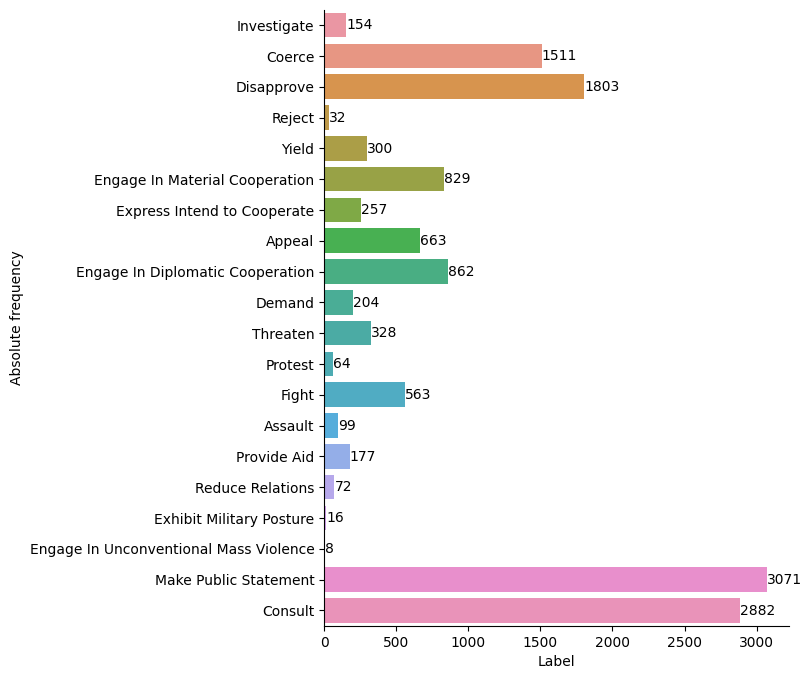

In [11]:
expl_new = data_new.explode("relations")
plt.figure(figsize=(6,8))
ax = sns.countplot(y = expl_new.relations)
ax.bar_label(ax.containers[0])
sns.despine()
plt.ylabel('Absolute frequency')
plt.xlabel('Label')

In [12]:

idx = []
for row in data_new.iterrows():
    if "Engage In Unconventional Mass Violence" in row[1]["relations"]: idx.append(row[0])
    #elif "Reject" in row[1]["relations"]: idx.append(row[0])
    #elif "Exhibit Military Posture" in row[1]["relations"]: idx.append(row[0])
#Drop unconventional mass violence because not represented 
data_rdy = data_new.drop(index = idx).reset_index().drop(columns = ["index"])

Text(0.5, 0, 'Label')

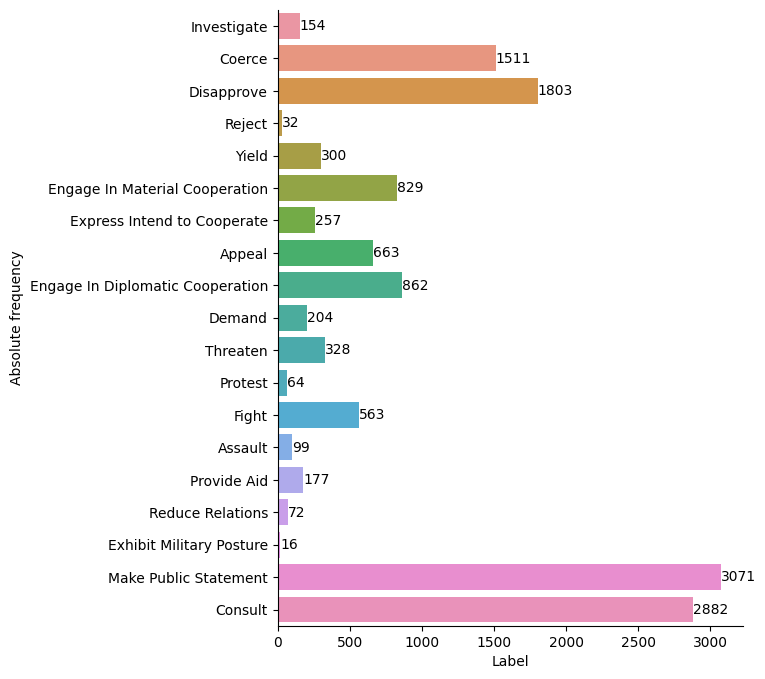

In [13]:
expl_3 = data_rdy.explode("relations")
plt.figure(figsize=(6,8))
ax = sns.countplot(y = expl_3.relations)
ax.bar_label(ax.containers[0])
sns.despine()
plt.ylabel('Absolute frequency')
plt.xlabel('Label')

In [14]:
data_rdy[["text","label"]].to_csv("data_src/unsupervised/unsupervised_data_preprocessed.csv")

In [26]:
data_rdy = pd.read_csv("data_src/unsupervised/unsupervised_data_preprocessed.csv", index_col= 0)
#train and validation data from DataAugementation.ipynb

train = pd.read_csv("data_src/unsupervised/train_0.csv", index_col= 0)
train["split"] = "training"
val = pd.read_csv("data_src/unsupervised/val_0.csv", index_col= 0)
val["split"] = "validation"
test = pd.read_csv("data_src/unsupervised/test_0.csv", index_col= 0)
test["split"] = "test"

full_set = pd.concat([train, val, test])

data_rdy.shape, train.shape, val.shape, test.shape, full_set.shape

((12594, 2), (16061, 3), (1881, 3), (1889, 3), (19831, 3))

### Pre- & Post-Plots

In [27]:
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'

In [30]:
order_1 = {
        "Make Public \nStatement":0,
        "Consult":3,
        "Disapprove":10,
        "Coerce":16,
        "Engage In \nDiplomatic \nCooperation":4,
        "Engage In \nMaterial \nCooperation":6,
        "Appeal":1,
        "Fight":18,
        "Threaten":12,
        "Yield":7,
        "Express Intend\nto Cooperate":2,        
        "Demand":9,
        "Provide Aid":5,
        "Investigate":8,
        "Assault":17,
        "Reduce \nRelations":15,
        "Protest":14,
        "Reject":19,
        "Exhibit Military \nPosture":20,
        "Engage In \nUnconventional \nMass Violence":21
}

order_2 = {
    "original":0,
    "training":1,
    "validation":2,
    "test":3
}

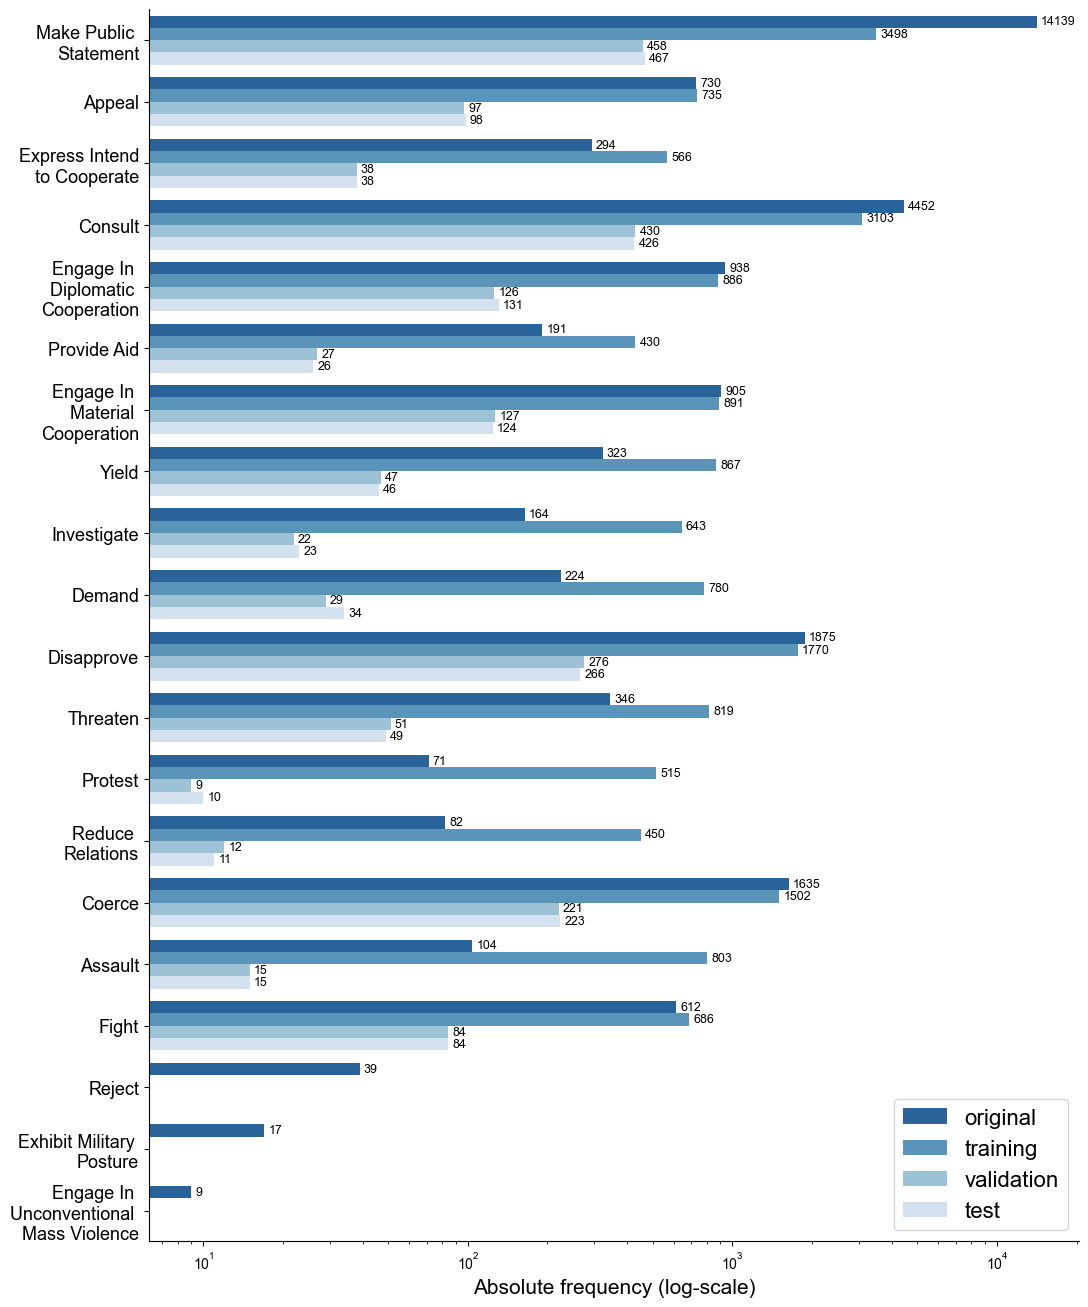

In [33]:
data = pd.read_csv("soft_data/data/out_data/softdata_concat_noents.csv", index_col = 0)
#extract the categorized relation from original df
data["label"] = data.label.apply(lambda x: strip_multiple_whitespaces(x.replace("<triplet>"," <triplet> ")))
relation = []
for row in data.iterrows():
    rel_iter = row[1]["label"] + " <triplet>"
    all_rels = re.findall("(?<=<obj> ).*?(?= <subj> | <triplet>)", rel_iter)
    relation.append(all_rels)
data["relations"] = relation 

expl = data.explode("relations")
expl["split"] = "original"

#extract the categorized relation from split df
full_set["label"] = full_set.label.apply(lambda x: strip_multiple_whitespaces(x.replace("<triplet>"," <triplet> ")))
relation = []
for row in full_set.iterrows():
    rel_iter = row[1]["label"] + " <triplet>"
    all_rels = re.findall("(?<=<obj> ).*?(?= <subj> | <triplet>)", rel_iter)
    relation.append(all_rels)
full_set["relations"] = relation 

expl1 = full_set.explode("relations")

all_expl = pd.concat([expl, expl1])
all_expl["relations"] = all_expl.relations.apply(lambda x: x.replace(
    "Provide Aid", "Provide Aid").replace(
    "Engage In Diplomatic Cooperation", "Engage In \nDiplomatic \nCooperation").replace(
    "Make Public Statement", "Make Public \nStatement").replace(
    "Express Intend to Cooperate","Express Intend\nto Cooperate").replace(
    "Engage In Material Cooperation", "Engage In \nMaterial \nCooperation").replace(
    "Exhibit Military Posture", "Exhibit Military \nPosture").replace(
    "Reduce Relations", "Reduce \nRelations").replace(
    "Express Intent to Cooperate","Express Intent \nto Cooperate").replace(
    "Engage In Unconventional Mass Violence","Engage In \nUnconventional \nMass Violence"))
all_expl["sort_1"] = all_expl.relations.map(order_1)
all_expl["sort_2"] = all_expl.split.map(order_2)
expl_sorted = all_expl.sort_values(by=["sort_1","sort_2"], ascending = True)

plt.figure(figsize=(12,16))
ax = sns.countplot(y = expl_sorted.relations, hue = expl_sorted.split, palette = "Blues_r")
ax.bar_label(ax.containers[0], padding = 3, fontsize = 9)
ax.bar_label(ax.containers[1], padding = 3, fontsize = 9)
ax.bar_label(ax.containers[2], padding = 3, fontsize = 9)
ax.bar_label(ax.containers[3], padding = 3, fontsize = 9)

sns.despine()
plt.xlabel('Absolute frequency (log-scale)', fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylabel("")
plt.yticks(fontsize = 13)
plt.xscale("log")
plt.legend(prop = {"size":16}, fontsize = 15)

df1 = pd.pivot_table(expl_sorted,
              index='relations',
              columns='split',
              aggfunc='size')

idx = df1.index.to_list()

In [15]:
seed0 = pd.concat([pd.read_csv("data_src/unsupervised/train_0.csv"), pd.read_csv("data_src/unsupervised/val_0.csv"), pd.read_csv("data_src/unsupervised/test_0.csv")])

#How many relations does each text have?
seed0["rel_count"] = seed0.label.apply(lambda x: x.count("<triplet>"))
for count in range(seed0.rel_count.max()):
    print(f"Count of sentences with {count + 1} relations: {seed0[seed0.rel_count == count + 1].shape[0]}")

#all sentences have only 1 relation

Count of sentences with 1 relations: 18947
Count of sentences with 2 relations: 754
Count of sentences with 3 relations: 130


In [16]:
130 / seed0.shape[0]

0.006555393071453784

# EDA with Pentacodes

In [6]:
data_rdy = pd.read_csv("data_src/unsupervised/unsupervised_data_preprocessed.csv", index_col= 0)
#train and validation data from DataAugementation.ipynb

train = pd.read_csv("data_src/unsupervised/train_0.csv", index_col= 0)
train["split"] = "training"
val = pd.read_csv("data_src/unsupervised/val_0.csv", index_col= 0)
val["split"] = "validation"
test = pd.read_csv("data_src/unsupervised/test_0.csv", index_col= 0)
test["split"] = "test"

full_set = pd.concat([train, val, test])

data_rdy.shape, train.shape, val.shape, test.shape, full_set.shape

((12594, 2), (16061, 3), (1881, 3), (1889, 3), (19831, 3))

In [7]:
order_2 = {
    "original":0,
    "training":1,
    "validation":2,
    "test":3
}

order_3 = {
    "Make a Statement":0,
    "Verbal Cooperation":1,
    "Material Cooperation":2,
    "Verbal Conflict":3,
    "Material Conflicht":4
}

In [8]:
data = pd.read_csv("soft_data/data/out_data/softdata_concat_noents.csv", index_col = 0)
data["split"] = "original"

#for full data
penta_map = []
last_txt = ""
for row in data.iterrows():
    trip_text = row[1]["label"]
    for key in cameo_to_penta.keys():
        if key in row[1]["label"]: trip_text = trip_text.replace(key, cameo_to_penta[key])
    penta_map.append([row[1]["text"], trip_text, row[1]["split"]])
penta = pd.DataFrame(penta_map, columns = ["text","label","split"])

#extract the categorized relation from original df
penta["label"] = penta.label.apply(lambda x: strip_multiple_whitespaces(x.replace("<triplet>"," <triplet> ")))
relation = []
for row in penta.iterrows():
    rel_iter = row[1]["label"] + " <triplet>"
    all_rels = re.findall("(?<=<obj> ).*?(?= <subj> | <triplet>)", rel_iter)
    relation.append(all_rels)
penta["relations"] = relation 
penta_exp = penta.explode("relations")

#for train/val/test
penta_map = []
last_txt = ""
for row in full_set.iterrows():
    trip_text = row[1]["label"]
    for key in cameo_to_penta.keys():
        if key in row[1]["label"]: trip_text = trip_text.replace(key, cameo_to_penta[key])
    penta_map.append([row[1]["text"], trip_text, row[1]["split"]])
penta_sets = pd.DataFrame(penta_map, columns = ["text","label","split"])

#extract the categorized relation from original df
penta_sets["label"] = penta_sets.label.apply(lambda x: strip_multiple_whitespaces(x.replace("<triplet>"," <triplet> ")))
relation = []
for row in penta_sets.iterrows():
    rel_iter = row[1]["label"] + " <triplet>"
    all_rels = re.findall("(?<=<obj> ).*?(?= <subj> | <triplet>)", rel_iter)
    relation.append(all_rels)
penta_sets["relations"] = relation 

penta_exp_sets = penta_sets.explode("relations")
penta_full = pd.concat([penta_exp, penta_exp_sets])

penta_full["sort_1"] = penta_full.relations.map(order_3)
penta_full["sort_2"] = penta_full.split.map(order_2)
penta_full = penta_full.sort_values(by=["sort_1","sort_2"], ascending = True)

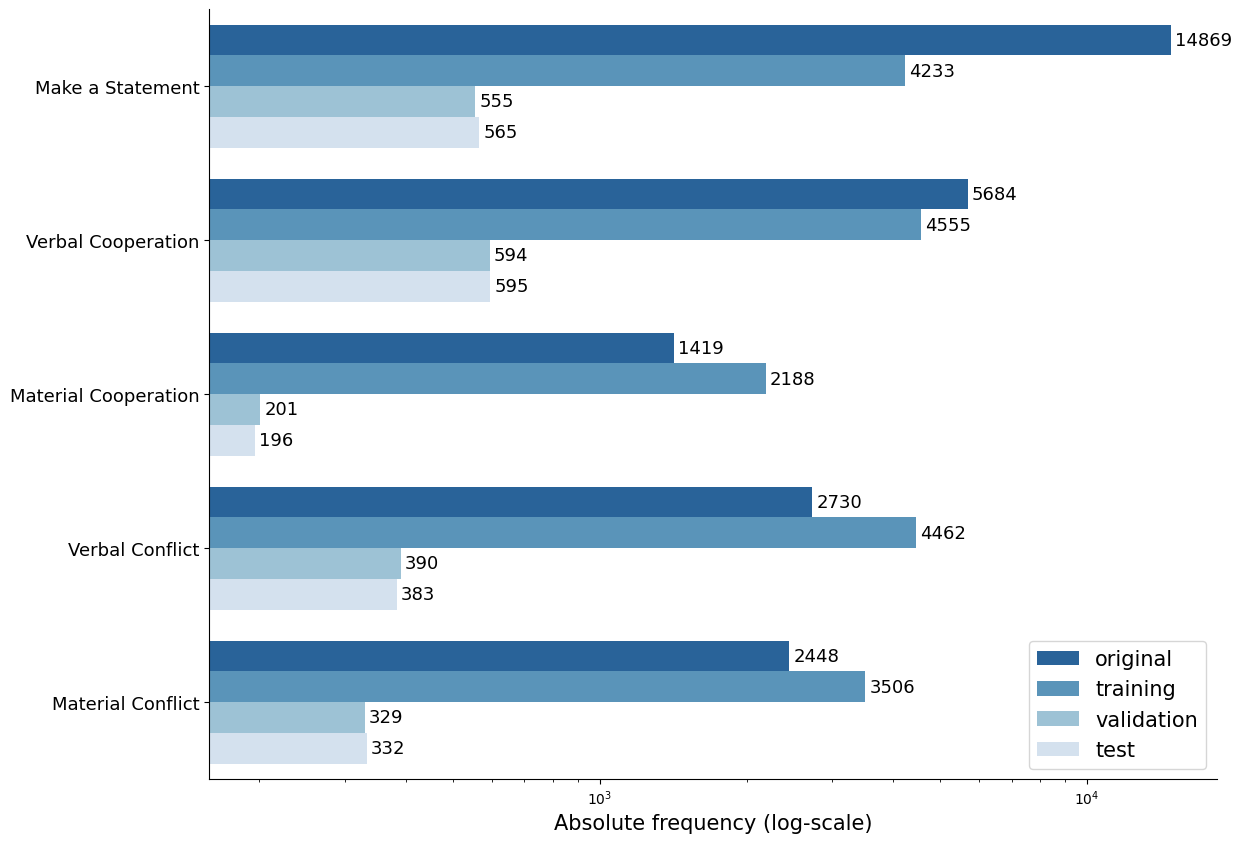

In [9]:
plt.figure(figsize=(13,10))
ax = sns.countplot(y = penta_full.relations, hue = penta_full.split, palette = "Blues_r")
ax.bar_label(ax.containers[0], padding = 3, fontsize = 13)
ax.bar_label(ax.containers[1], padding = 3, fontsize = 13)
ax.bar_label(ax.containers[2], padding = 3, fontsize = 13)
ax.bar_label(ax.containers[3], padding = 3, fontsize = 13)

sns.despine()
plt.xlabel('Absolute frequency (log-scale)', fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylabel("")
plt.yticks(fontsize = 13)
plt.xscale("log")
plt.legend(prop = {"size":15}, fontsize = 15)

df1 = pd.pivot_table(penta_full,
              index='relations',
              columns='split',
              aggfunc='size')

idx = df1.index.to_list()